# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression()

In [3]:
clr.score(X_test, y_test)

0.7188953853974145

In [4]:
clr.coef_

array([-1.41404335e-01,  4.81102373e-02, -8.40548143e-04,  2.00042793e+00,
       -1.80128739e+01,  4.06244143e+00, -2.31660654e-03, -1.50620416e+00,
        3.42350977e-01, -1.39154224e-02, -9.29812974e-01,  9.52495986e-03,
       -4.67914487e-01])

In [5]:
clr.intercept_

34.58207029557392

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([34.62868904, 20.52633292, 27.48672629, 24.64851918, 21.98430679])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([34.62868904, 20.52633292, 27.48672629, 24.64851918, 21.98430679])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32), op_version=12),
                   numpy.array([clr.intercept_], dtype=numpy.float32),
                   output_names=['Y'], op_version=12)
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)},
                              dtype=numpy.float32)

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([34.628685, 20.526333, 27.486725, 24.648518, 21.984306],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
from mlprodict.tools.asv_options_helper import get_ir_version_from_onnx
# line needed when onnx is more recent than onnxruntime
onnx_model32.ir_version = get_ir_version_from_onnx()
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([34.628685, 20.526333, 27.486725, 24.648518, 21.984306],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64), op_version=12),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'], op_version=12)
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)},
                              dtype=numpy.float64)

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([34.62868904, 20.52633292, 27.48672629, 24.64851918, 21.98430679])

And the *onnxruntime* version of it.

In [15]:
oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
ort_pred[:5]

array([34.62868904, 20.52633292, 27.48672629, 24.64851918, 21.98430679])

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, kernel=DotProduct(sigma_0=1))

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32)
oinf32 = OnnxInference(onnxgau32, runtime="python")
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([33.8125 , 20.28125, 27.84375, 24.375  , 21.     , 25.78125,
        7.5625 , 37.5    , 32.4375 , 22.90625, 17.6875 , 32.71875,
       20.3125 , 15.5    , 32.     , 36.25   , 23.0625 , 30.40625,
       27.03125, 18.625  , 18.5    , 23.90625, 25.4375 , 13.5625 ,
       15.5    ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64), dtype=numpy.float64)
oinf64 = OnnxInference(onnxgau64, runtime="python")
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([33.70833856, 20.31447315, 27.82453337, 24.37788068, 20.93056882,
       25.67478333,  6.98653965, 37.4769457 , 32.82301829, 23.20902979,
       17.69656786, 33.38649241, 19.920409  , 15.59606776, 32.3195529 ,
       36.54101361, 23.0629222 , 30.54514886, 26.84760276, 18.3227035 ,
       18.78816161, 23.86972687, 25.46659466, 13.50325892, 15.65966059])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.50253659, 0.52802859, 0.53248958, 0.57596035, 0.69707475])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.50253659, 0.52802859, 0.53248958, 0.57596035, 0.69707475])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,value[0],shape[0],value[1],shape[1]
0,nb_results,-1,9,9.000000e+00,OK,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,4.971762e-08,OK,X,"[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3...","(127, 13)","[[0.03768, 80.0, 1.52, 0.0, 0.404, 7.274, 38.3...","(127, 13)"
2,abs-diff,1,0,3.122782e-02,e<0.1,GPmean,"[[33.8125, 20.28125, 27.84375, 24.375, 21.0, 2...","(1, 127)","[[33.70833856490208, 20.314473151345737, 27.82...","(1, 127)"
3,abs-diff,2,0,5.398157e-08,OK,kgpd_MatMulcst,"[[0.10793, 0.63796, 7.36711, 0.1712, 0.03113, ...","(13, 379)","[[0.10793, 0.63796, 7.36711, 0.1712, 0.03113, ...","(13, 379)"
4,abs-diff,3,0,8.383728e-09,OK,kgpd_Addcst,[728.5445],"(1,)",[728.5445007368253],"(1,)"
5,abs-diff,4,0,5.604237e-08,OK,gpr_MatMulcst,"[0.09818853, -0.17121932, -0.33198282, 0.27722...","(379,)","[0.09818852357881183, -0.1712193176426608, -0....","(379,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,[[0.0]],"(1, 1)",[[0.0]],"(1, 1)"
7,abs-diff,6,0,1.920940e-07,OK,kgpd_Y0,"[[283912.8, 254441.84, 261303.53, 286234.8, 27...","(127, 379)","[[283912.8332177392, 254441.82822216966, 26130...","(127, 379)"
8,abs-diff,7,0,1.920940e-07,OK,kgpd_C0,"[[283912.8, 254441.84, 261303.53, 286234.8, 27...","(127, 379)","[[283912.8332177392, 254441.82822216966, 26130...","(127, 379)"
9,abs-diff,8,0,3.122782e-02,e<0.1,gpr_Y0,"[33.8125, 20.28125, 27.84375, 24.375, 21.0, 25...","(127,)","[33.70833856490208, 20.314473151345737, 27.824...","(127,)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

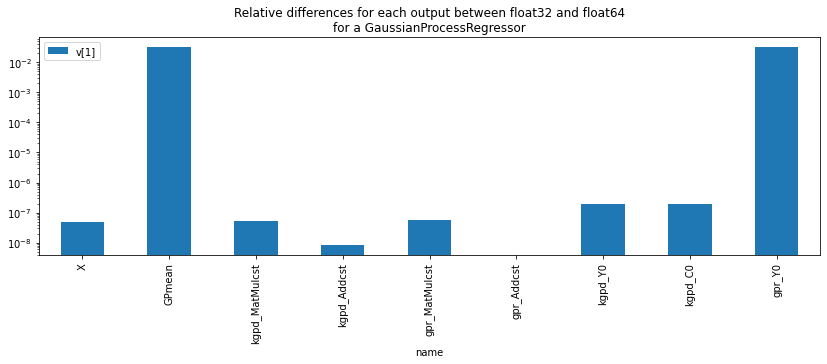

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.46322418e-06, 1.46380626e-06, 1.64349331e-06, 1.79524068e-06,
       2.38663051e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.46322418e-06, 1.46380626e-06, 1.64349331e-06, 1.79524068e-06,
       2.38663051e-06])

Last verification.

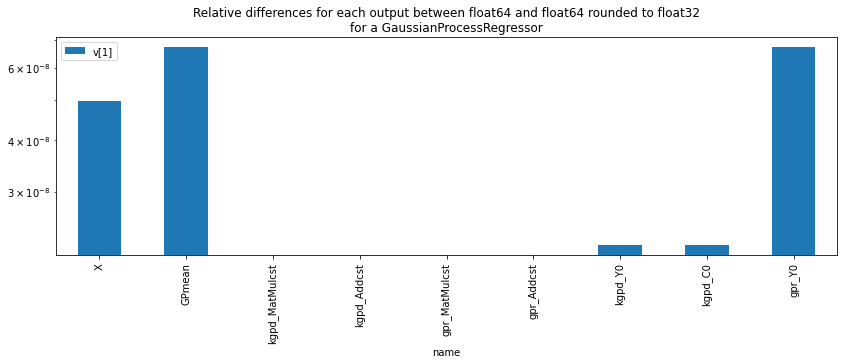

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");